<a href="https://colab.research.google.com/github/p4triko/Microtransaction-Prediction-IDS25/blob/patrick/Project_B10_Predict_Microtransaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [1]:
# General
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for model training
from sklearn.model_selection import train_test_split

Loading in the dataset, two options are available. Chooose ONE: either the GitHub URL, if that fails, upload the data manually by downloading the csv file from the repository.

In [2]:

url = 'https://raw.githubusercontent.com/p4triko/Microtransaction-Prediction-IDS25/refs/heads/main/online_gaming_behavior_dataset.csv'

try:
  df = pd.read_csv(url)
  print("Data loaded from GitHub")
except Exception as e:
  print("Github loading failed: ", e)
  print("Trying manual upload")
  from google.colab import files
  uploaded = files.upload()
  name = list(uploaded.keys())[0]
  df = pd.read_csv(name)
  print(f"Loaded data from the file: {name}")

Data loaded from GitHub


Initial inspections, ensure everything was properly loaded

In [3]:
df.shape

(40034, 13)

In [4]:
df.head(10)

,PlayerID,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,16.271119,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,5.525961,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,8.223755,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,5.265351,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,15.531945,0,Medium,2,131,95,37,Medium
5,9005,37,Male,Europe,RPG,20.561855,0,Easy,2,81,74,22,Low
6,9006,25,Male,USA,Action,9.752716,0,Hard,1,50,13,2,Low
7,9007,25,Female,Asia,RPG,4.401729,0,Medium,10,48,27,23,Medium
8,9008,38,Female,Europe,Simulation,18.152733,0,Easy,5,101,23,41,Medium
9,9009,38,Female,Other,Sports,23.942772,0,Easy,13,95,99,36,High


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   PlayTimeHours              40034 non-null  float64
 6   InGamePurchases            40034 non-null  int64  
 7   GameDifficulty             40034 non-null  object 
 8   SessionsPerWeek            40034 non-null  int64  
 9   AvgSessionDurationMinutes  40034 non-null  int64  
 10  PlayerLevel                40034 non-null  int64  
 11  AchievementsUnlocked       40034 non-null  int64  
 12  EngagementLevel            40034 non-null  object 
dtypes: float64(1), int64(7), object(5)
memory usag

Before cleaning let's check the target distribution

In [6]:
target_column = "InGamePurchases"
df[target_column].value_counts(normalize=True)

,proportion
InGamePurchases,
0,0.799146
1,0.200854


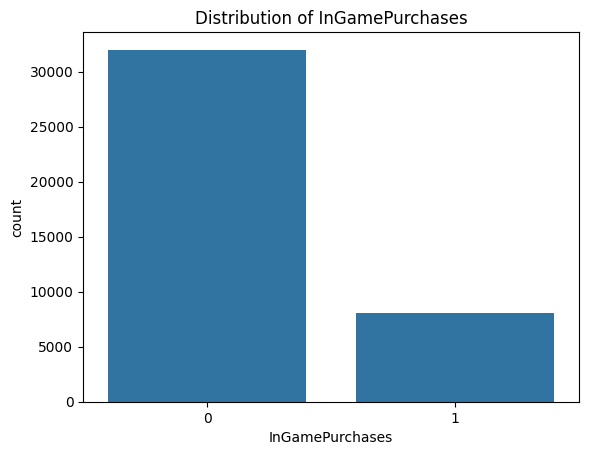

In [7]:
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()

Data cleaning and preparation

In [8]:
# Drop PlayerID column, as it offers no predictive value.
if 'PlayerID' in df.columns:
  df = df.drop(columns=["PlayerID"])

# Convert AvgSessionDurationMinutes to hours for better interpretability
if 'AvgSessionDurationMinutes' in df.columns:
  df['AvgSessionDurationHours'] = df['AvgSessionDurationMinutes'] / 60
  df = df.drop(columns=["AvgSessionDurationMinutes"])

# Let's check if there are any missing values
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Age                        0
Gender                     0
Location                   0
GameGenre                  0
PlayTimeHours              0
InGamePurchases            0
GameDifficulty             0
SessionsPerWeek            0
PlayerLevel                0
AchievementsUnlocked       0
EngagementLevel            0
AvgSessionDurationHours    0
dtype: int64


In [9]:
# Get rid of logically impossible values, such as:
# SessionsPerWeek should be at least 1.
# PlayTimeHours is more realistic, shouldn't be almost 24 hours.
if "SessionsPerWeek" in df.columns:
  before = len(df)
  df = df[df["SessionsPerWeek"] >= 1]
  print(f"SessionsPerWeek cleaned, {before - len(df)} rows with a value of 0.")

if "PlayTimeHours" in df.columns:
  before = len(df)
  df = df[df["PlayTimeHours"] <= 15]
  print(f"PlayTimeHours cleaned, {before - len(df)} rows with an unrealistic playtime.")

SessionsPerWeek cleaned, 1967 rows with a value of 0.
PlayTimeHours cleaned, 14322 rows with an unrealistic playtime.


In [14]:
df.head(10)

,Age,Gender,Location,GameGenre,PlayTimeHours,InGamePurchases,GameDifficulty,SessionsPerWeek,PlayerLevel,AchievementsUnlocked,EngagementLevel,AvgSessionDurationHours
1,29,Female,USA,Strategy,5.525961,0,Medium,5,11,10,Medium,2.400000
2,22,Female,USA,Sports,8.223755,0,Easy,16,35,41,High,2.366667
3,35,Male,USA,Action,5.265351,1,Easy,9,57,47,Medium,1.416667
6,25,Male,USA,Action,9.752716,0,Hard,1,13,2,Low,0.833333
7,25,Female,Asia,RPG,4.401729,0,Medium,10,27,23,Medium,0.800000
10,17,Male,USA,Strategy,4.829916,0,Hard,8,14,12,High,1.583333
11,36,Female,Asia,Simulation,5.535981,1,Easy,16,62,31,High,2.066667
15,16,Male,Europe,RPG,7.951511,0,Medium,10,58,24,High,2.600000
20,39,Female,USA,Sports,1.722581,0,Easy,2,34,37,Medium,2.950000
22,42,Male,USA,Sports,10.448126,0,Medium,2,81,5,Low,2.000000


In [11]:
df.shape

(23745, 12)

Check target distribution after cleaning

In [12]:
df[target_column].value_counts(normalize=True)

,proportion
InGamePurchases,
0,0.795999
1,0.204001


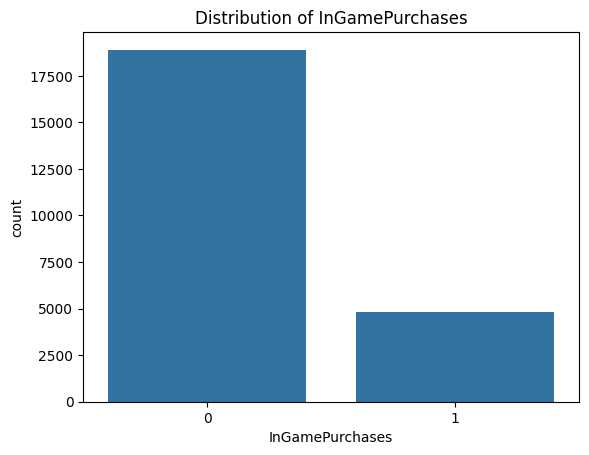

In [13]:
sns.countplot(x=target_column, data=df)
plt.title(f"Distribution of {target_column}")
plt.show()